# IBM watsonx.governance evaluation of Agentic App developed using Langgraph

This notebook demonstrates how to use the Agentic AI evaluators from IBM watsonx.governance for governing your applications right in your development environment.

The sample app shown here is an Agentic RAG example for querying information about IBM watsonx.governance capabilities. It makes use of OpenAI's `gpt-4o-mini` LLM for answer generation, and `text-embedding-3-small` embedding model for converting the queries to embeddings. 


### Install the dependencies

In [ ]:
%pip install --quiet "ibm-watsonx-gov[agentic,visualization]" langchain-chroma langchain-openai pyppeteer nest_asyncio

### Accept the credentials

The following code snippet ensures that specific environment variables are set without being hardcoded in the script. It does so by prompting the user for input only if the variables are not already set.

The environment variables need to be set are:

1. **OPENAI_API_KEY:** This is required for Open AI capabilities.
2. **WXG_API_KEY:** This is required for IBM watsonx.governance capabilities.

Optionally, if you are using IBM watsonx.governance as a service in a regional data center other than **Dallas (us-south), in Texas US**, you need to set  **WXG_URL**. You can check the regional availability of the watsonx services [here](https://www.ibm.com/docs/en/watsonx/saas?topic=integrations-regional-availability-cloud#regional-availability-of-the-watsonx-services)

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("WXG_API_KEY")

OPENAI_API_KEY:  ········
WXG_API_KEY:  ········


### Set up the local vector store

We have created a local vector store comprising of a few medium posts by [Manish Bhide](https://medium.com/@manish.bhide) and [Ravi Chamarthy](https://medium.com/@ravi-chamarthy). These posts focus on the various capabilities in IBM watsonx.governance (and erstwhile IBM Watson OpenScale). Hence, our queries will focus on these capabilities covered in the above posts. 

For user's convenience, the vector store has been compressed. The following cell downloads the compressed file, extracts it locally, and initializes the Chroma store. 

In [2]:
%rm medium_db.zip
%rm -r medium_db/

!wget https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip

rm: medium_db.zip: No such file or directory
rm: medium_db/: No such file or directory
--2025-03-28 15:17:54--  https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip
20.207.73.82thub.com (github.com)... 
connected. to github.com (github.com)|20.207.73.82|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip [following]
--2025-03-28 15:17:55--  https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1203223 (1.1M) [application/zip]
Saving to: ‘medium_db.zip’

medium_db.zip       100%[==================

In [3]:
import zipfile

with zipfile.ZipFile("medium_db.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

openai_embed_model = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = Chroma(
    collection_name="medium_articles",
    embedding_function=openai_embed_model,
    persist_directory="./medium_db"
)

### Set up the State

The `ibm-watsonx-gov` library provides a pydantic based state class - `EvaluationState`. This provides various attributes for your use e.g. `input_text` is for storing the application input, `context` is for storing the context documents. For simple applications, developers can extend this class for their use. 

In [5]:
from ibm_watsonx_gov.entities.state import EvaluationState

class AppState(EvaluationState):
    pass

### Set up the evaluator

For evaluating your Agentic AI applications, you need to first instantiate the `AgenticEvaluation` class. This class defines a few evaluators to compute the different metrics.

We are going to use the following evaluators in this notebook:
1. `evaluate_context_relevance` : To compute context relevance metric of your content retrieval tool.
2. `evaluate_faithfulness`: To compute faithfulness metric of your answer generation tool. This metric does not require ground truth.
3. `evaluate_answer_similarity`: To compute answer similarity metric of your answer generation tool. This metric requires ground truth for computation.


In [6]:
from ibm_watsonx_gov.evaluate.agentic_evaluation import AgenticEvaluation

evaluator = AgenticEvaluation()

### Build your langgraph application

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.config import RunnableConfig

#### Define content retrieval node

We are using a Similarity with Threshold Retrieval strategy. This will fetch the top 3 documents matching the query if the threshold score is more than 0.1

The `retrieval_node` tool defined below is decorated with IBM watsonx.governance evaluator `evaluate_context_relevance` tool to compute the context relevance metric. This node reads the user query from the `input_text` attribute from the application state and writes the result into the `context` attribute back to the application state.

In [8]:
@evaluator.evaluate_context_relevance
def retrieval_node(state: AppState, config: RunnableConfig):
    similarity_threshold_retriever = vector_store.as_retriever(search_type="similarity_score_threshold",
                                                               search_kwargs={"k": 3,
                                                                              "score_threshold": 0.1})
    context = similarity_threshold_retriever.invoke(state.input_text)
    return {
        "context": [doc.page_content for doc in context]
    }

#### Define answer generation tool

We are using `gpt-4o-mini` to generate an answer for our query.

The `generate_node` defined below is decorated with two evaluators `evaluate_faithfulness` and `evaluate_answer_similarity` for computing answer quality metrics. Like in the previous cell, this node reads the user query from the `input_text` attribute from the application state, the `context` attribute consists of the context chunks. After generating the answer, the node writes the result into the `generated_text` attribute back to the application state.

In [9]:
@evaluator.evaluate_faithfulness
@evaluator.evaluate_answer_similarity
def generate_node(state: AppState, config: RunnableConfig):
    generate_prompt = ChatPromptTemplate.from_template(
        "Answer the following question based on the given context:\n"
        "Context: {context}\n"
        "Question: {input_text}\n"
        "Answer:"
    )

    formatted_prompt = generate_prompt.invoke(
        {"input_text": state.input_text, "context": "\n".join(state.context)})
    llm = ChatOpenAI(model="gpt-4o-mini")
    result = llm.invoke(formatted_prompt)
    return {
        "generated_text": result.content
    }

#### Assemble your application

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


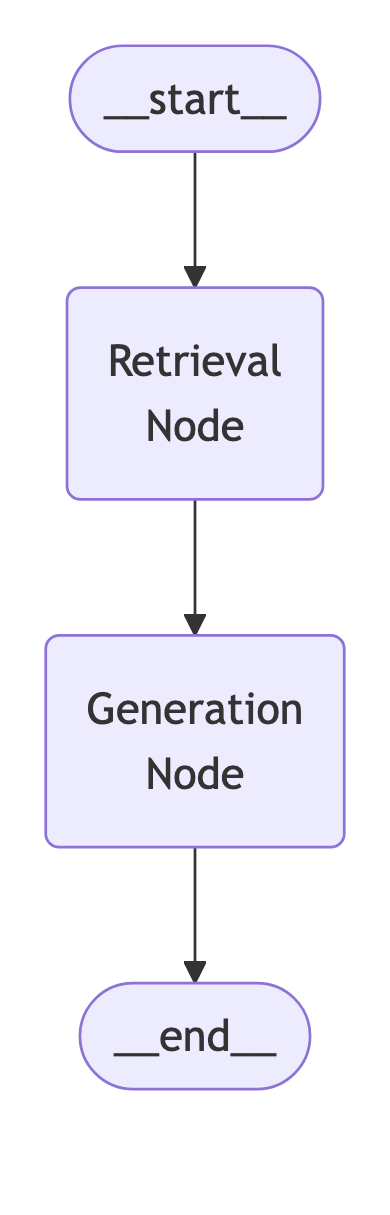

In [18]:
from langgraph.graph import START, END, StateGraph

graph = StateGraph(AppState)

# Add nodes
graph.add_node("Retrieval \nNode", retrieval_node)
graph.add_node("Generation \nNode", generate_node)

# Add edges
graph.add_edge(START, "Retrieval \nNode")
graph.add_edge("Retrieval \nNode", "Generation \nNode")
graph.add_edge("Generation \nNode", END)

# Compile the graph
rag_app = graph.compile()

# Show
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        rag_app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.NATURAL,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=5,
        ),
        width=150,  # Image width in pixels
        height=100  # Image height in pixels
    )
)

### Do a single invocation

Now the application is invoked for a single row of data. You will see two new keys as the input:
1. `ground_truth`: As the name suggests, this attribute holds the ground truth for your input text. This is needed for the answer similarity metric, which is a reference based metric. For the other metrics, this is not required.
2. `record_id`: This is required so that IBM watsonx.governance can keep track of individual rows and associate metrics with each row. This will become evident when we do batch invocation in the next cell.

In [11]:
result = rag_app.invoke({"input_text": "What is concept drift?", "ground_truth": "Concept drift occurs when the statistical properties of the target variable change over time, causing a machine learning model’s predictions to become less accurate.", "record_id": "12"})

### Prepare the app results
By default, the metric result will only include the `record_id` column from the input data.  
If you want to include additional data like input, output or ground_truth, you can specify them in the `input_data` parameter.

In [12]:
import pandas as pd

result_df = pd.DataFrame([result])
input_data = result_df[["input_text", "record_id", "generated_text"]] # Add the columns which should be part of the application metric results
metric_result = evaluator.get_metrics_df(input_data=input_data)

### Display the metric results

In [13]:
from ibm_watsonx_gov.visualizations.visualization_utils import display_table

display_table(metric_result)

ITable(caption='Records', classes='display nowrap compact violations_table', style='table-layout:auto;width:au…

### Invoke the graph on multiple rows

IBM watsonx.governance evaluation of Agentic Applications can be done with batch invocation too. Here, a dataframe with questions and ground truths for those questions have been defined. The dataframe index has been used as  `record_id` to uniquely identify each row. 

In [ ]:
import pandas as pd

question_bank_df = pd.read_csv("https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_question_bank.csv")
question_bank_df["record_id"] = question_bank_df.index.astype(str)
question_bank_df

### Display the metric results

In [ ]:
result = rag_app.batch(inputs=question_bank_df.to_dict("records"))

In [ ]:
result_df = pd.DataFrame(result)
input_data = result_df[["input_text", "record_id"]] # Add the columns which should be part of the application metric results
metric_result = evaluator.get_metrics_df(input_data=input_data)

display_table(metric_result)

### CHANGELOG

#### [0.0.3] - 2025-03-28
##### Added
- Removed `transform_to_wide_format` method and use `display_table` to show metrics results in wide and sortable format
- Changed the graph image drawing to use pyppeteer+nest_asyncio

#### [0.0.2] - 2025-03-06
##### Added
- `transform_to_wide_format` method to show metrics results in wide format
- Better documentation in cells to explain various attributes of the state.

#### [0.0.1] - 2025-03-01
##### Added
- First set of evaluator nodes from IBM watsonx.governance



Developed by [Prem Piyush Goyal](https://www.linkedin.com/in/prempiyush/)